In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
import seaborn as sb
from scipy.stats import skew
import statsmodels.api as sm
import re

# Load the data
train_df = pd.read_csv("/Users/sandhyajeyaraj/Ml hackathon/train_(2)_(1)_(1).csv")
avg_rent_df = pd.read_csv("/Users/sandhyajeyaraj/Ml hackathon/avg_rent_(1)_(1)_(1).csv")
dist_from_city_centre_df = pd.read_csv("/Users/sandhyajeyaraj/Ml hackathon/dist_from_city_centre_(1)_(1)_(1).csv")

# Merge dataframes
train_df = train_df.merge(avg_rent_df, on="location", how="left")
train_df = train_df.merge(dist_from_city_centre_df, on="location", how="left")

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
train_df.isnull().sum()

ID                   0
area_type            0
availability         0
location             1
size                14
society           4428
total_sqft           0
bath                65
balcony            504
price                0
avg_2bhk_rent     6991
dist_from_city    1026
dtype: int64

In [5]:

def convert_sqft(value):
    try:
        # Handle ranges like "1076 - 1199"
        if '-' in value:
            vals = list(map(float, value.split('-')))
            return sum(vals) / 2
        
        # Handle units like "1 acre", "167Sq. Meter", etc.
        if 'acre' in value.lower():
            return float(re.findall(r'\d+\.?\d*', value)[0]) * 43560
        elif 'sq. meter' in value.lower():
            return float(re.findall(r'\d+\.?\d*', value)[0]) * 10.764
        elif 'sq. yard' in value.lower():
            return float(re.findall(r'\d+\.?\d*', value)[0]) * 9
        elif 'perch' in value.lower():
            return float(re.findall(r'\d+\.?\d*', value)[0]) * 272.25
        else:
            # Handle purely numeric values
            return float(value)
    except:
        return None  # Return None for invalid entries

In [6]:
# Feature Engineering
def preprocess_data(data_set):
    data_set.drop(columns = 'ID', inplace = True)
    #data_set.drop(columns='society',inplace= True)
    data_set.drop(columns='availability',inplace= True)
    # Handle missing values (e.g., fill with median for numerical, 'Unknown' for categorical)
    data_set.location.replace(np.NAN, 'Others', inplace = True)
    data_set.balcony.replace(np.NAN, data_set.balcony.median(), inplace = True)
    data_set.bath.replace(np.NAN, data_set.bath.median(), inplace = True)
    data_set['avg_2bhk_rent'].fillna(data_set['avg_2bhk_rent'].median(), inplace=True)
    data_set['dist_from_city'].fillna(data_set['dist_from_city'].median(), inplace=True)

    # Apply the function to the total_sqft column
    data_set['total_sqft_cleaned'] = data_set['total_sqft'].apply(convert_sqft)
    data_set.total_sqft_cleaned.replace(np.NAN, data_set.total_sqft_cleaned.mean(), inplace = True)

    # convert size to Int
    data_set['size'] = data_set['size'].str.replace('bedroom', '', case=False).str.strip()
    data_set['size'] = data_set['size'].str.replace('BHK', '', case=False).str.strip()
    data_set['size'] = data_set['size'].str.replace('RK', '', case=False).str.strip()
    data_set['size'].replace(np.NAN, data_set['size'].median(), inplace = True)    
    data_set['size_num'] = data_set['size'].str.extract('(\d+)').fillna(1).astype(int)
    
    # Create new features
    #data_set['price_per_sqft'] = data_set['price'] / data_set['total_sqft_cleaned']
    data_set['sqft_city_distance'] = data_set['total_sqft_cleaned'] / (data_set['dist_from_city']) 
    data_set['rent_per_bhk'] = (data_set['total_sqft_cleaned'] * data_set['avg_2bhk_rent']) / (data_set['size_num'])
    data_set['sqft_per_bath'] = data_set['total_sqft_cleaned'] / (data_set['bath'])
    data_set['bathrooms_per_room'] = data_set['bath'] / data_set['size_num']
    data_set['area_per_room'] = data_set['total_sqft_cleaned'] / data_set['size_num']
    

    # Handle categorical variables
    categorical_cols = ['area_type', 'society','location']
    #numerical_cols = ['total_sqft_cleaned', 'bath', 'balcony', 'sqft_city_distance', 'rent_per_bhk', 'size_num', 'bathrooms_per_room', 
     #                 'sqft_per_bath', 'avg_2bhk_rent', 'dist_from_city', 'location_count', 'area_per_room']

    numerical_cols = ['total_sqft_cleaned', 'bath', 'balcony', 'sqft_city_distance', 'size_num', 
                      'bathrooms_per_room', 'area_per_room']

    return data_set, categorical_cols, numerical_cols

In [7]:
def remove_outlier(df_encode):
    df_num = df_encode.select_dtypes(include=np.number)
    fig, ax = plt.subplots(2,3,figsize=(15,8))
    for variable, subplot in zip(df_num.columns, ax.flatten()):
        z = sb.boxplot(x=df_num[variable], orient = "h", whis = 1.5, ax=subplot)
        z.set_xlabel(variable, fontsize = 20)

    data1 = df_num
    
    q1=data1.quantile(0.25)
    q3=data1.quantile(0.75)
    IQR = q3 - q1
    lb = q1 - 1.5 * IQR
    ub = q3 + 1.5 * IQR

    df_out = df_num[~((data1 < lb) | (data1 > ub)).any(axis=1)]
    df_out=df_out.reset_index(drop=True)
    return df_out;

In [8]:
train_df, categorical_cols, numerical_cols = preprocess_data(train_df)
train_final = train_df.copy()
train_final

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,area_type,location,size,society,total_sqft,bath,balcony,price,avg_2bhk_rent,dist_from_city,total_sqft_cleaned,size_num,sqft_city_distance,rent_per_bhk,sqft_per_bath,bathrooms_per_room,area_per_room
0,Super built-up Area,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07,11500.0,19.3,1056.0,2,54.715026,6072000.0,528.0,1.000000,528.0
1,Plot Area,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00,14981.0,34.6,2600.0,4,75.144509,9737650.0,520.0,1.250000,650.0
2,Built-up Area,Uttarahalli,3,NaN,1440,2.0,3.0,62.00,19750.0,12.9,1440.0,3,111.627907,9480000.0,720.0,0.666667,480.0
3,Super built-up Area,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00,14981.0,21.4,1521.0,3,71.074766,7595367.0,507.0,1.000000,507.0
4,Super built-up Area,Kothanur,2,NaN,1200,2.0,1.0,51.00,16375.0,11.8,1200.0,2,101.694915,9825000.0,600.0,1.000000,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,Plot Area,Parappana Agrahara,1,NaN,1200,1.0,0.0,45.00,14981.0,14.6,1200.0,1,82.191781,17977200.0,1200.0,1.000000,1200.0
10652,Super built-up Area,Bhoganhalli,2,Srhemay,1260,2.0,1.0,69.90,14981.0,15.3,1260.0,2,82.352941,9438030.0,630.0,1.000000,630.0
10653,Super built-up Area,Doddanakundi Industrial Area 2,2,NaN,1092,2.0,1.0,49.00,14981.0,13.4,1092.0,2,81.492537,8179626.0,546.0,1.000000,546.0
10654,Super built-up Area,Kachanayakanahalli,2,ICoolon,827,2.0,0.0,34.00,14981.0,14.4,827.0,2,57.430556,6194643.5,413.5,1.000000,413.5


In [9]:
#train_df = remove_outlier(train_df)

In [10]:
train_df.drop(columns=['avg_2bhk_rent', 'dist_from_city', 'rent_per_bhk', 'sqft_per_bath'],inplace= True)
train_df

,area_type,location,size,society,total_sqft,bath,balcony,price,total_sqft_cleaned,size_num,sqft_city_distance,bathrooms_per_room,area_per_room
0,Super built-up Area,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07,1056.0,2,54.715026,1.000000,528.0
1,Plot Area,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00,2600.0,4,75.144509,1.250000,650.0
2,Built-up Area,Uttarahalli,3,NaN,1440,2.0,3.0,62.00,1440.0,3,111.627907,0.666667,480.0
3,Super built-up Area,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00,1521.0,3,71.074766,1.000000,507.0
4,Super built-up Area,Kothanur,2,NaN,1200,2.0,1.0,51.00,1200.0,2,101.694915,1.000000,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,Plot Area,Parappana Agrahara,1,NaN,1200,1.0,0.0,45.00,1200.0,1,82.191781,1.000000,1200.0
10652,Super built-up Area,Bhoganhalli,2,Srhemay,1260,2.0,1.0,69.90,1260.0,2,82.352941,1.000000,630.0
10653,Super built-up Area,Doddanakundi Industrial Area 2,2,NaN,1092,2.0,1.0,49.00,1092.0,2,81.492537,1.000000,546.0
10654,Super built-up Area,Kachanayakanahalli,2,ICoolon,827,2.0,0.0,34.00,827.0,2,57.430556,1.000000,413.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

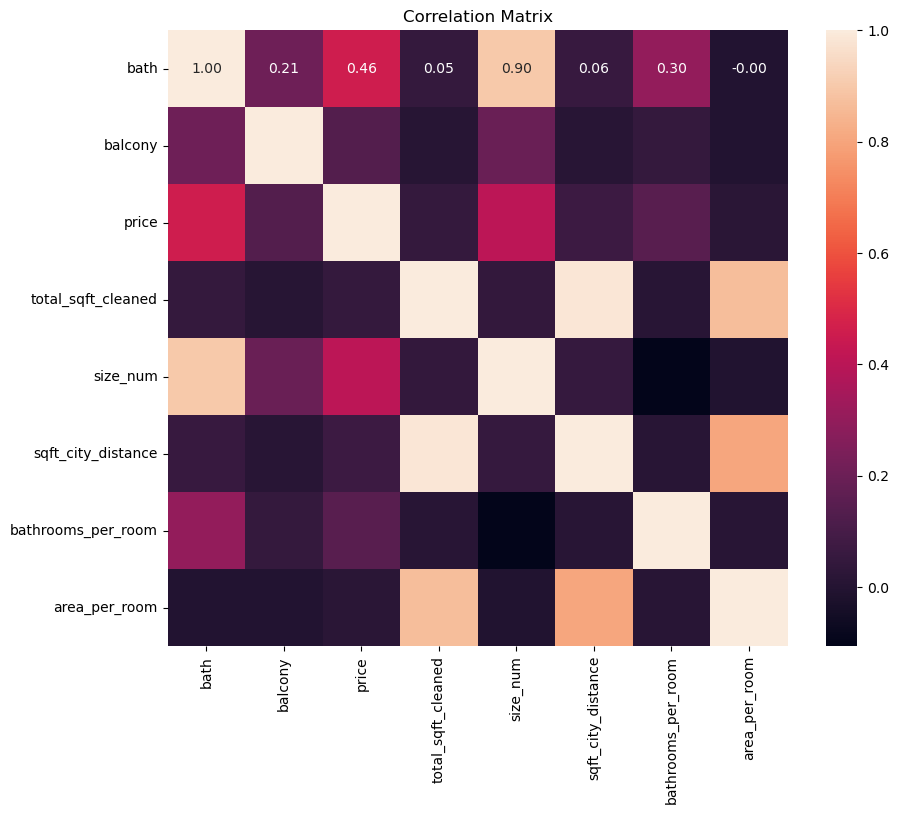

In [11]:
heatmap_data = train_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = heatmap_data.corr()

# Optional: Visualize with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [12]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [13]:
# Split data
X = train_df.drop('price', axis=1)
y = train_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for preprocessing
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

In [14]:
# Define a list of models to evaluate
models = [
    ('Random Forest', Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])),
    ('Gradient Boosting', Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])),
    ('XGBoost', Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ]))
]


In [15]:
# Evaluate each model
for model_name, model in models:
    rmse = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{model_name} RMSE: {rmse}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest RMSE: 84.80439439090071
Gradient Boosting RMSE: 82.95709346907479
XGBoost RMSE: 101.56394698578077


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
best_model_name, best_model = min(models, key=lambda x: evaluate_model(x[1], X_train, y_train, X_test, y_test))

print(f"\nBest Model: {best_model_name}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Best Model: Gradient Boosting


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
# Define hyperparameter grid for tuning
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'regressor__n_estimators': [200, 300, 400],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [4, 5, 6],
        'regressor__subsample': [0.8, 0.9]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5],
        'regressor__subsample': [0.8, 0.9],
        'regressor__colsample_bytree': [0.8, 0.9]
    }

In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=42) 

In [19]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, 
                          cv=cv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluate the model
rmse_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_test=np.sqrt(mean_squared_error(y_test,y_pred_test))

r2_train=r2_score(y_train,y_pred_train)
r2_test=r2_score(y_test,y_pred_test)

res=[rmse_train,rmse_test,r2_train,r2_test]

print(f"RMSE for train: {rmse_train}") 
print(f"RMSE for test: {rmse_test}") 
print(f"R2_score for train: {r2_train}") 
print(f"R2_score for test: {r2_test}") 
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RMSE for train: 40.81856475278492
RMSE for test: 81.01319692159363
R2_score for train: 0.9179754338919366
R2_score for test: 0.6697333788575957
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}


# TEST

In [513]:
test = pd.read_csv("/Users/sandhyajeyaraj/Ml hackathon/test_(2)_(1)_(1).csv")

# Merge avg_rent_data with the train dataset on 'location'
data_set_test = test.merge(avg_rent_df, on='location', how='left')

# Merge dist_data with the already merged dataset
data_set_test = data_set_test.merge(dist_from_city_centre_df, on='location', how='left')
data_set_test_ID = data_set_test.copy()

In [514]:
data_set_test, categorical_cols, numerical_cols = preprocess_data(data_set_test)
data_set_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,area_type,location,size,society,total_sqft,bath,balcony,avg_2bhk_rent,dist_from_city,total_sqft_cleaned,size_num,sqft_city_distance,rent_per_bhk,sqft_per_bath,bathrooms_per_room,area_per_room
0,Super built-up Area,Chamrajpet,2,NaN,650,1.0,1.0,15875.0,6.7,650.0,2,97.014925,5.159375e+06,650.00,0.500000,325.000000
1,Super built-up Area,7th Phase JP Nagar,3,SrncyRe,1370,2.0,1.0,14981.0,11.0,1370.0,3,124.545455,6.841323e+06,685.00,0.666667,456.666667
2,Super built-up Area,Whitefield,3,AjhalNa,1725,3.0,2.0,14981.0,17.3,1725.0,3,99.710983,8.614075e+06,575.00,1.000000,575.000000
3,Built-up Area,Jalahalli,2,NaN,1000,2.0,0.0,11000.0,16.6,1000.0,2,60.240964,5.500000e+06,500.00,1.000000,500.000000
4,Plot Area,TC Palaya,1,NaN,1350,1.0,0.0,14981.0,12.2,1350.0,1,110.655738,2.022435e+07,1350.00,1.000000,1350.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,Built-up Area,Whitefield,5,ArsiaEx,3453,4.0,0.0,14981.0,17.3,3453.0,5,199.595376,1.034588e+07,863.25,0.800000,690.600000
2660,Super built-up Area,Richards Town,4,NaN,3600,5.0,2.0,14981.0,5.6,3600.0,4,642.857143,1.348290e+07,720.00,1.250000,900.000000
2661,Built-up Area,Raja Rajeshwari Nagar,2,Mahla T,1141,2.0,1.0,14981.0,15.3,1141.0,2,74.575163,8.546660e+06,570.50,1.000000,570.500000
2662,Super built-up Area,Padmanabhanagar,4,SollyCl,4689,4.0,1.0,14981.0,11.3,4689.0,4,414.955752,1.756148e+07,1172.25,1.000000,1172.250000


In [515]:
test_result = best_model.predict(data_set_test)
test_result

array([ 49.80648117,  67.89947369, 101.51387725, ...,  53.132918  ,
       377.91652456,  32.38558966])

In [516]:
# Create DataFrame to save the results
predictions_df = pd.DataFrame({
    'ID': data_set_test_ID['ID'],
    'price': test_result
})
predictions_df['price'] = predictions_df['price'].round(3)

In [517]:
predictions_df

,ID,price
0,0,49.806
1,1,67.899
2,2,101.514
3,3,44.730
4,4,81.875
...,...,...
2659,2659,198.286
2660,2660,429.661
2661,2661,53.133
2662,2662,377.917


In [518]:
predictions_df.to_csv('solution-report.csv', index=False)